<a href="https://colab.research.google.com/github/AnkushMalaker/Hand-Gesture-Emoji-Detector/blob/master/Model%20training%2C%20evaluation%20and%20explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [0]:
%tensorflow_version 2.x

## Downloading dataset

Go to kaggle > account > create API and upload the kaggle.json onto the working directory from the pane on the left. This is required to download datasets using commandline from kaggle

In [0]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Initiate dataset donwload

In [3]:
!kaggle datasets download -d gti-upm/leapgestrecog

 99% 2.12G/2.13G [00:57<00:00, 50.0MB/s]
100% 2.13G/2.13G [00:57<00:00, 39.6MB/s]


Unzip into data directory

In [0]:
%%bash
rm -rf data
mkdir data
unzip -q leapgestrecog.zip -d data

# Imports

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

More data preprocessing.  
Note: The data loading function is referenced from [here](https://www.kaggle.com/benenharrington/hand-gesture-recognition-database-with-cnn).

In [6]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('data/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 1,
 '02_l': 3,
 '03_fist': 2,
 '04_fist_moved': 0,
 '05_thumb': 5,
 '06_index': 8,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 4,
 '10_down': 9}

In [122]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('data/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('data/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('data/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((128, 128))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
    print("Processing foler %d out of 10" %i)
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) 
print("Features shape: %s" %str(x_data.shape))
print("Labels shape: %s" %str(y_data.shape))

Processing foler 0 out of 10
Processing foler 1 out of 10
Processing foler 2 out of 10
Processing foler 3 out of 10
Processing foler 4 out of 10
Processing foler 5 out of 10
Processing foler 6 out of 10
Processing foler 7 out of 10
Processing foler 8 out of 10
Processing foler 9 out of 10
Features shape: (20000, 128, 128)
Labels shape: (20000, 1)


In [31]:
y_onehot = keras.utils.to_categorical(y_data)
print(y_onehot.shape)

(20000, 10)


# Setup training and testing batches

In [0]:
train_set_x = tf.data.Dataset.from_tensor_slices(x_data[:-1000,:,:])
train_set_y = tf.data.Dataset.from_tensor_slices(y_onehot[:-1000])
train_set = tf.data.Dataset.zip((train_set_x, train_set_y)).batch(64).shuffle(20000).cache()
test_set_x = tf.data.Dataset.from_tensor_slices(x_data[-1000:,:,:])
test_set_y = tf.data.Dataset.from_tensor_slices(y_onehot[-1000:])
test_set = tf.data.Dataset.zip((test_set_x, test_set_y)).batch(64).shuffle(20000).cache()

# Function to create model

In [0]:
def create_model(model_type='max_pool', dropout_rate=0):
    if model_type == 'max_pool':
        img_input = keras.Input(shape=(128,128,1))

        conv1 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(img_input)
        mx_pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        drop1 = keras.layers.Dropout(dropout_rate)(mx_pool)

        conv2 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(drop1)
        mx_pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        drop2 = keras.layers.Dropout(dropout_rate)(mx_pool2)

        conv3 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(drop2)
        mx_pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        drop3 = keras.layers.Dropout(dropout_rate)(mx_pool3)

        # Flattening the layers
        flatten1 = keras.layers.Flatten()(drop3)

        # Adding a fully connected layer
        dense1 = keras.layers.Dense(units=128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(flatten1)
        output_layer = keras.layers.Dense(units=10, activation='softmax')(dense1)

        model = keras.Model(inputs=img_input, outputs=output_layer)
        return model
    else:
        img_input = keras.Input(shape=(128,128,1))

        conv1 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(img_input)
        avg_pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(avg_pool1)
        avg_pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = keras.layers.Convolution2D(32, (3, 3), activation='relu')(avg_pool2)
        avg_pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        flatten1 = keras.layers.Flatten()(avg_pool3)

        dense1 = keras.layers.Dense(units=128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(flatten1)
        output_layer = keras.layers.Dense(units=10, activation='softmax')(dense1)

        model = keras.Model(inputs=img_input, outputs=output_layer)
        return model

In [112]:
model = create_model('avg_pool')
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 32)        0  

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)
opt = tf.keras.optimizers.Adam(lr_schedule)

model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


# Callbacks for early stopping

In [0]:
es_callback = [
    tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)
]
# "wait for 5 epochs, check if the val_accuracy increases by 0.01, if not, stop and restore the weights that give best val_accuracy"

# Train model and plot history

In [117]:
history = model.fit(train_set,epochs=10,verbose=1,validation_data=test_set,callbacks=es_callback)

Epoch 1/10
297/297 [==============================] - 10s 33ms/step - loss: 0.6478 - accuracy: 0.9719 - val_loss: 0.7176 - val_accuracy: 0.8650
Epoch 2/10
297/297 [==============================] - 10s 33ms/step - loss: 0.4103 - accuracy: 0.9986 - val_loss: 0.3977 - val_accuracy: 0.9960
Epoch 3/10
297/297 [==============================] - 10s 33ms/step - loss: 0.3000 - accuracy: 0.9998 - val_loss: 0.3085 - val_accuracy: 0.9880
Epoch 4/10
297/297 [==============================] - 10s 32ms/step - loss: 0.2340 - accuracy: 0.9995 - val_loss: 0.2963 - val_accuracy: 0.9780
Epoch 5/10
297/297 [==============================] - 10s 32ms/step - loss: 0.4766 - accuracy: 0.9326 - val_loss: 0.3241 - val_accuracy: 0.9920
Epoch 6/10
297/297 [==============================] - 10s 32ms/step - loss: 0.2320 - accuracy: 0.9991 - val_loss: 0.2358 - val_accuracy: 0.9920
Epoch 7/10
297/297 [==============================] - 10s 32ms/step - loss: 0.1813 - accuracy: 0.9998 - val_loss: 0.1939 - val_accuracy:

In [118]:
model.evaluate(test_set)

16/16 [==============================] - 0s 13ms/step - loss: 0.3977 - accuracy: 0.9960


[0.397713303565979, 0.9959999918937683]

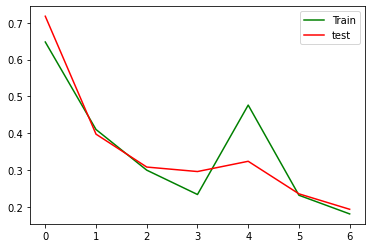

In [119]:
fig = plt.figure()
plt.plot(history.epoch,  history.history['loss'] ,label='Train', color='green')
plt.plot(history.epoch,  history.history['val_loss'] ,label='test', color='red')
plt.legend()
plt.show()

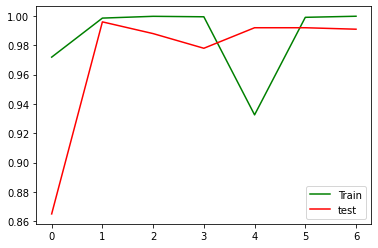

In [120]:
fig = plt.figure()
plt.plot(history.epoch,  history.history['accuracy'] ,label='Train', color='green')
plt.plot(history.epoch,  history.history['val_accuracy'] ,label='test', color='red')
plt.legend()
plt.show()

# Save Model

In [0]:
model_json = model.to_json()
with open("modelHand.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('modelHand.h5')